In [92]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error,median_absolute_error,r2_score
from datetime import datetime

import plotnine
from plotnine import ggplot, aes, geom_line, scale_x_datetime, geom_point, xlab, ylab
from plotnine.scales.scale_color import scale_color_hue
from plotnine.facets.facet_grid import facet_grid

In [93]:
df = pd.read_csv("cpu_mem_req_lat_211022_190123.csv")
df.head(5)

,Date,Process CPU usage,Process memory usage,Request count,Reponse time
0,2022-10-21 12:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00,3.77,6.30,312000.0,0.191


In [94]:
df.dropna(inplace=True)
df.columns = ['timestamp', 'cpu', 'memory', 'request', 'latency']
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M'))
df

,timestamp,cpu,memory,request,latency
0,2022-10-21 12:00:00,3.83,6.26,316000.0,0.198
1,2022-10-21 13:00:00,5.01,6.27,436000.0,0.252
2,2022-10-21 14:00:00,4.38,6.29,376000.0,0.230
3,2022-10-21 15:00:00,4.34,6.29,378000.0,0.200
4,2022-10-21 16:00:00,3.77,6.30,312000.0,0.191
...,...,...,...,...,...
2156,2023-01-19 08:00:00,1.27,3.26,204000.0,0.157
2157,2023-01-19 09:00:00,1.35,3.26,211000.0,0.153
2158,2023-01-19 10:00:00,1.44,3.27,235000.0,0.141
2159,2023-01-19 11:00:00,2.23,3.27,644000.0,0.104


In [95]:
plotnine.options.figure_size = (23, 4.8)

def plot_data(data, metric):
  return ggplot(data) + aes(x='timestamp', y=metric) + geom_line() + scale_x_datetime()

In [96]:
#separates 80% of this data
training_data_len = math.floor(len(df)*.8)

### Modelagem dos dados

Para começar a modelagem é necessário, primeiramente, definir as camadas da nossa rede neural convolucional. A primeira camada é a de entrada e onde será definida a convulação da rede neural, que arbitrariamente, definida como 48.

In [97]:
numerical_i = tf.keras.layers.Input((48,1))
numerical = tf.keras.layers.Conv1D(20,4)(numerical_i)
numerical = tf.keras.layers.Flatten()(numerical)
dense = tf.keras.layers.Dense(300,'relu')(numerical)
out=tf.keras.layers.Dense(48,'relu')(dense)

##CPU

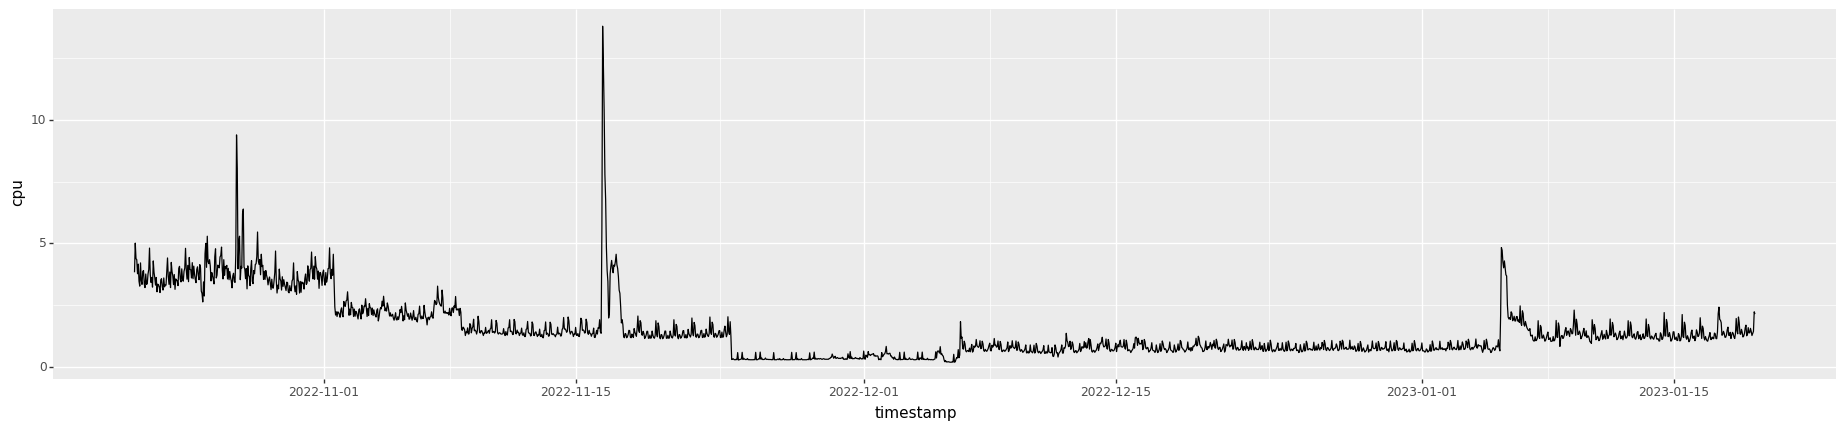

In [98]:
print(plot_data(df, 'cpu'))

In [99]:
##CPU
#creating a training dataset
train_cpu = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_cpu['cpu'] = df[0:training_data_len]['cpu']
train_cpu.set_index('timestamp',inplace = True)

l=48
h=48

X_cpu=[]
Y_cpu=[]

for i in range(l,train_cpu.shape[0]-h):
  f=train_cpu.iloc[i-l:i]['cpu'].values
  y=train_cpu.iloc[i:i+h]['cpu'].values

  X_cpu.append(f)
  Y_cpu.append(y)

X_cpu=np.array(X_cpu)
Y_cpu=np.array(Y_cpu)

#creating the test base
test_cpu = pd.DataFrame(df[training_data_len:]['timestamp'])
test_cpu['cpu'] = df[training_data_len:]['cpu']
test_cpu.set_index('timestamp',inplace = True)

Xv_cpu=[]
Yv_cpu=[]

for i in range(l, test_cpu.shape[0]-h):
  f=test_cpu.iloc[i-l:i]['cpu'].values
  y=test_cpu.iloc[i:i+h]['cpu'].values

  Xv_cpu.append(f)
  Yv_cpu.append(y)

Xv_cpu=np.array(Xv_cpu)
Yv_cpu=np.array(Yv_cpu)

In [100]:
len(Xv_cpu)

337

In [101]:
start_cpu = time.time()

In [102]:
model_cpu=tf.keras.Model(numerical_i,out)
model_cpu.compile('adam','mae')
model_cpu.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 20)            100       
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               270300    
                                                                 
 dense_5 (Dense)             (None, 48)                14448     
                                                                 
Total params: 284,848
Trainable params: 284,848
Non-trainable params: 0
_________________________________________________________________


In [103]:
#Treinamento: 10 épocas para treinamento do modelo.
model_cpu.fit(X_cpu,Y_cpu,batch_size=1,shuffle=True,epochs=10)

Epoch 1/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.4556
Epoch 2/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.3929
Epoch 3/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.3551
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.3260
Epoch 5/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.3134
Epoch 6/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.3099
Epoch 7/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2955
Epoch 8/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2791
Epoch 9/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.2748
Epoch 10/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2756


In [104]:
#Gerando as previsões do modelo
predictions_cpu=model_cpu.predict(Xv_cpu)

11/11 [==============================] - 0s 2ms/step


In [105]:
p_base_cpu = np.ones(Yv_cpu.shape)*np.median(Y_cpu,axis=0)

In [106]:
end_cpu = time.time()

In [107]:
print('Erro médio absoluto :', mean_absolute_error(Yv_cpu, p_base_cpu))
print('Erro médio quadrado :', mean_squared_error(Yv_cpu, p_base_cpu))
print('Coeficiente de determinação (R²):', r2_score(Yv_cpu, p_base_cpu))
print("Tempo de execução:", end_cpu-start_cpu)

Erro médio absoluto : 0.4729577769535113
Erro médio quadrado : 0.5018112156899104
Coeficiente de determinação (R²): -0.679539800895645
Tempo de execução: 61.94553899765015


Text(0, 0.5, 'Consumo')

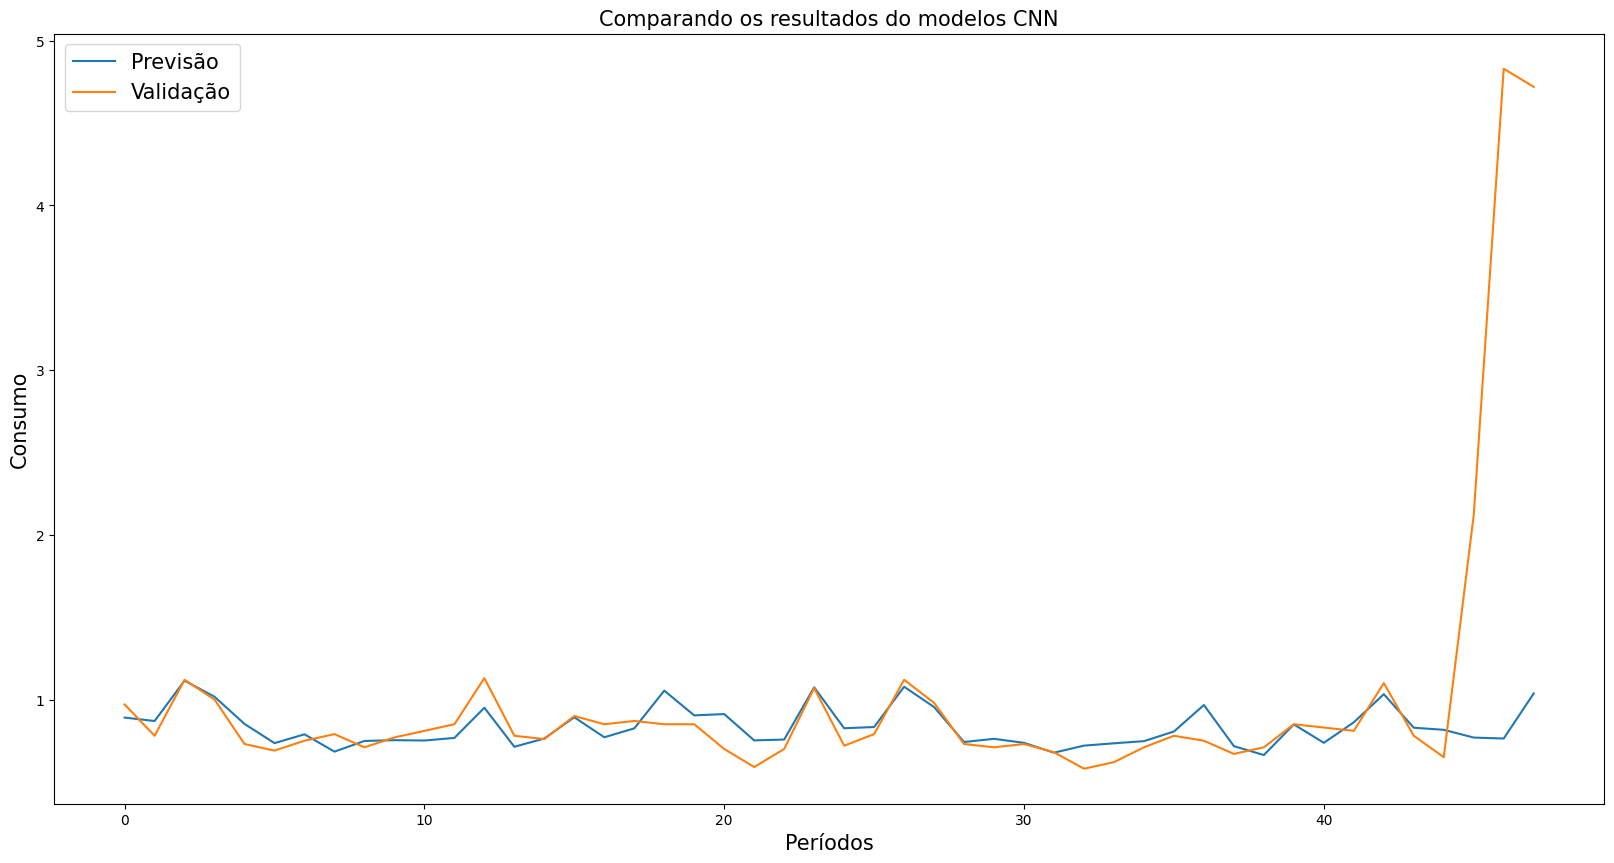

In [108]:
pd.DataFrame({'p':predictions_cpu[0,:], 'y':Yv_cpu[0,:]}).plot(figsize=(20,10))
plt.title('Comparando os resultados do modelos CNN',size=15)
plt.legend(['Previsão','Validação'],fontsize=15)
plt.xlabel('Períodos',size=15)
plt.ylabel('Consumo',size=15)

##MEMORY

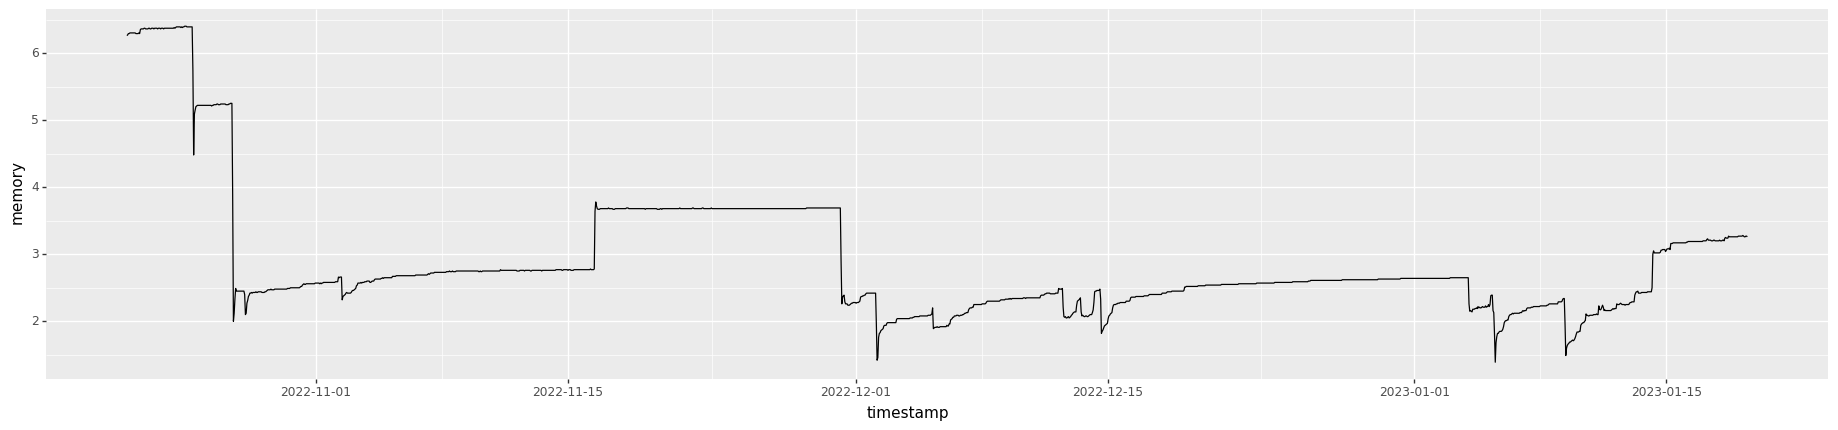

In [109]:
print(plot_data(df, 'memory'))

In [110]:
##MEMORY
#creating a training dataset
train_memory = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_memory['memory'] = df[0:training_data_len]['memory']
train_memory.set_index('timestamp',inplace = True)

l=48
h=48

X_memory=[]
Y_memory=[]

for i in range(l,train_memory.shape[0]-h):
  f=train_memory.iloc[i-l:i]['memory'].values
  y=train_memory.iloc[i:i+h]['memory'].values

  X_memory.append(f)
  Y_memory.append(y)

X_memory=np.array(X_memory)
Y_memory=np.array(Y_memory)

#creating the test base
test_memory = pd.DataFrame(df[training_data_len:]['timestamp'])
test_memory['memory'] = df[training_data_len:]['memory']
test_memory.set_index('timestamp',inplace = True)

Xv_memory=[]
Yv_memory=[]

for i in range(l, test_memory.shape[0]-h):
  f=test_memory.iloc[i-l:i]['memory'].values
  y=test_memory.iloc[i:i+h]['memory'].values

  Xv_memory.append(f)
  Yv_memory.append(y)

Xv_memory=np.array(Xv_memory)
Yv_memory=np.array(Yv_memory)

In [111]:
start_memory = time.time()

In [112]:
model_memory=tf.keras.Model(numerical_i,out)
model_memory.compile('adam','mae')
model_memory.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 20)            100       
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               270300    
                                                                 
 dense_5 (Dense)             (None, 48)                14448     
                                                                 
Total params: 284,848
Trainable params: 284,848
Non-trainable params: 0
_________________________________________________________________


In [113]:
#Treinamento: 10 épocas para treinamento do modelo.
model_memory.fit(X_memory,Y_memory,batch_size=1,shuffle=True,epochs=10)

Epoch 1/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1822
Epoch 2/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1715
Epoch 3/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1744
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1688
Epoch 5/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1688
Epoch 6/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1667
Epoch 7/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.1606
Epoch 8/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1640
Epoch 9/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.1619
Epoch 10/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.1570


In [114]:
#Gerando as previsões do modelo
predictions_memory=model_memory.predict(Xv_memory)

11/11 [==============================] - 0s 2ms/step


In [115]:
p_base_memory = np.ones(Yv_memory.shape)*np.median(Y_memory,axis=0)

In [116]:
end_memory = time.time()

In [117]:
print('Erro médio absoluto :', mean_absolute_error(Yv_memory, p_base_memory))
print('Erro médio quadrado :', mean_squared_error(Yv_memory, p_base_memory))
print('Coeficiente de determinação (R²):', r2_score(Yv_memory, p_base_memory))
print("Tempo de execução:", end_memory-start_memory)

Erro médio absoluto : 0.4863816765578643
Erro médio quadrado : 0.26783289441147334
Coeficiente de determinação (R²): -0.10400237872966354
Tempo de execução: 62.851558208465576


Text(0, 0.5, 'Consumo')

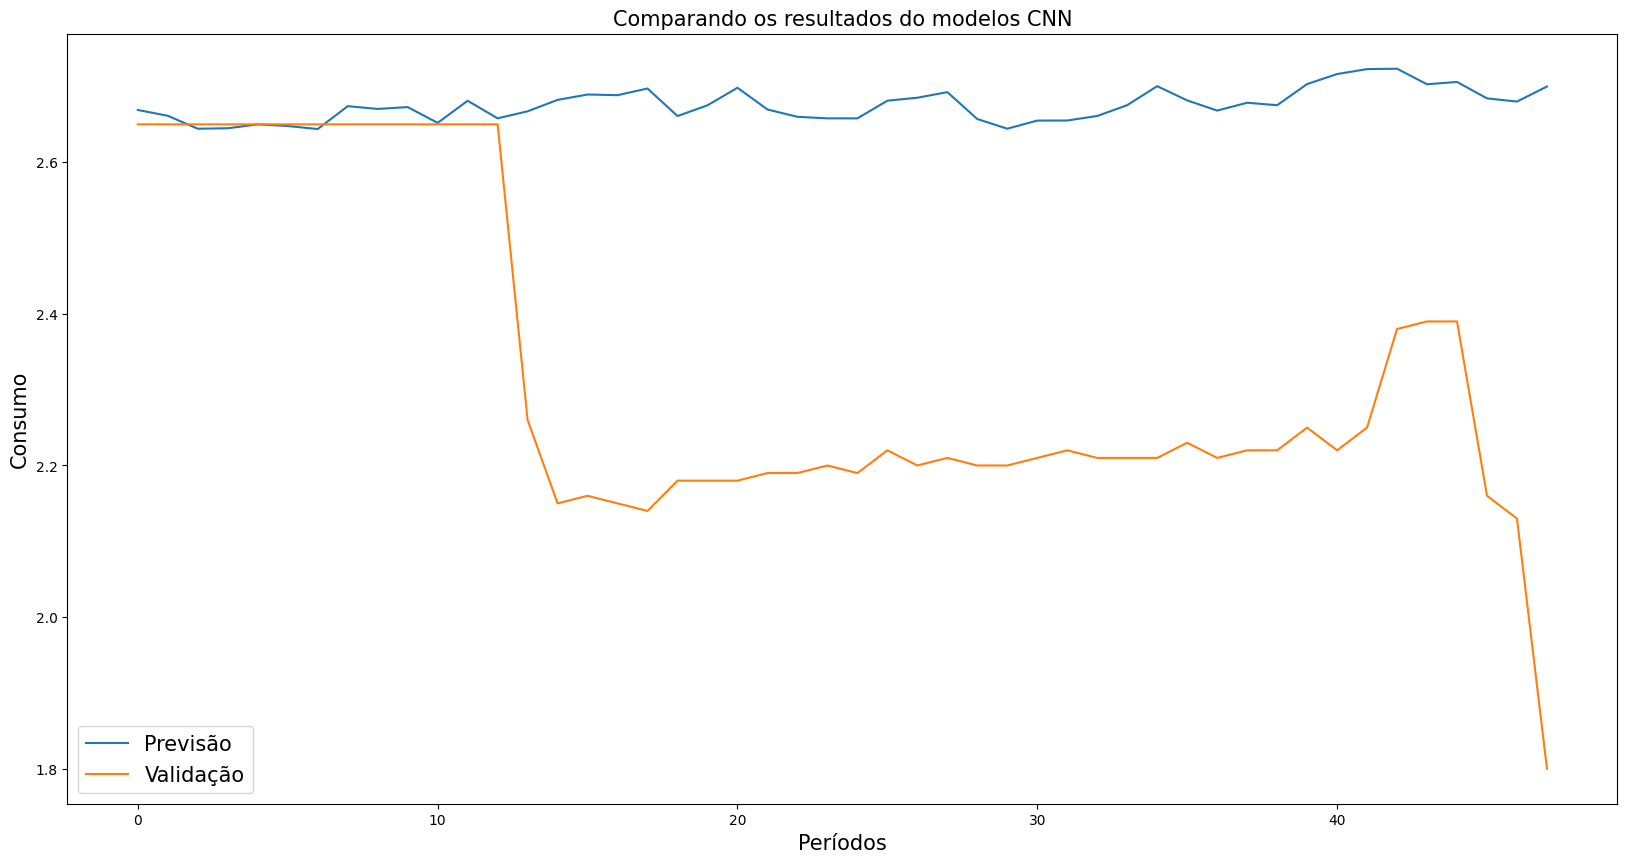

In [118]:
pd.DataFrame({'p':predictions_memory[0,:], 'y':Yv_memory[0,:]}).plot(figsize=(20,10))
plt.title('Comparando os resultados do modelos CNN',size=15)
plt.legend(['Previsão','Validação'],fontsize=15)
plt.xlabel('Períodos',size=15)
plt.ylabel('Consumo',size=15)

##REQUEST

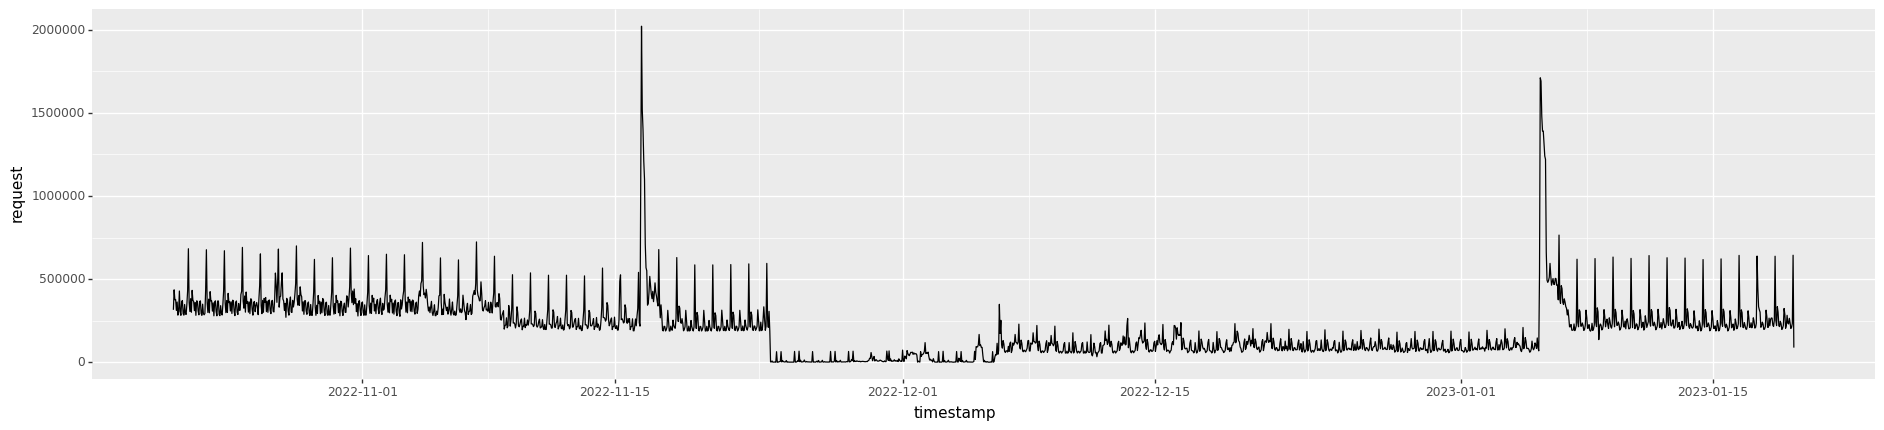

In [119]:
print(plot_data(df, 'request'))

In [120]:
##REQUEST
#creating a training dataset
train_request = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_request['request'] = df[0:training_data_len]['request']
train_request.set_index('timestamp',inplace = True)

l=48
h=48

X_request=[]
Y_request=[]

for i in range(l,train_request.shape[0]-h):
  f=train_request.iloc[i-l:i]['request'].values
  y=train_request.iloc[i:i+h]['request'].values

  X_request.append(f)
  Y_request.append(y)

X_request=np.array(X_request)
Y_request=np.array(Y_request)

#creating the test base
test_request = pd.DataFrame(df[training_data_len:]['timestamp'])
test_request['request'] = df[training_data_len:]['request']
test_request.set_index('timestamp',inplace = True)

Xv_request=[]
Yv_request=[]

for i in range(l, test_request.shape[0]-h):
  f=test_request.iloc[i-l:i]['request'].values
  y=test_request.iloc[i:i+h]['request'].values

  Xv_request.append(f)
  Yv_request.append(y)

Xv_request=np.array(Xv_request)
Yv_request=np.array(Yv_request)

In [121]:
start_request = time.time()

In [122]:
model_request=tf.keras.Model(numerical_i,out)
model_request.compile('adam','mae')
model_request.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 20)            100       
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               270300    
                                                                 
 dense_5 (Dense)             (None, 48)                14448     
                                                                 
Total params: 284,848
Trainable params: 284,848
Non-trainable params: 0
_________________________________________________________________


In [123]:
#Treinamento: 10 épocas para treinamento do modelo.
model_request.fit(X_request,Y_request,batch_size=1,shuffle=True,epochs=10)

Epoch 1/10
1632/1632 [==============================] - 7s 4ms/step - loss: 44103.7734
Epoch 2/10
1632/1632 [==============================] - 6s 3ms/step - loss: 39051.6211
Epoch 3/10
1632/1632 [==============================] - 6s 4ms/step - loss: 37473.4258
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 36263.6797
Epoch 5/10
1632/1632 [==============================] - 6s 4ms/step - loss: 35624.0352
Epoch 6/10
1632/1632 [==============================] - 6s 4ms/step - loss: 35377.2539
Epoch 7/10
1632/1632 [==============================] - 7s 4ms/step - loss: 34966.9453
Epoch 8/10
1632/1632 [==============================] - 6s 4ms/step - loss: 34512.2930
Epoch 9/10
1632/1632 [==============================] - 6s 4ms/step - loss: 34291.6523
Epoch 10/10
1632/1632 [==============================] - 6s 4ms/step - loss: 33684.9805


In [124]:
#Gerando as previsões do modelo
predictions_request=model_request.predict(Xv_request)

11/11 [==============================] - 0s 2ms/step


In [125]:
p_base_request = np.ones(Yv_request.shape)*np.median(Y_request,axis=0)

In [126]:
end_request = time.time()

In [127]:
print('Erro médio absoluto :', mean_absolute_error(Yv_request, p_base_request))
print('Erro médio quadrado :', mean_squared_error(Yv_request, p_base_request))
print('Coeficiente de determinação (R²):', r2_score(Yv_request, p_base_request))
print("Tempo de execução:", end_request-start_request)

Erro médio absoluto : 160667.69287833828
Erro médio quadrado : 69060655021.01878
Coeficiente de determinação (R²): -0.5448066078307158
Tempo de execução: 82.70159888267517


Text(0, 0.5, 'Consumo')

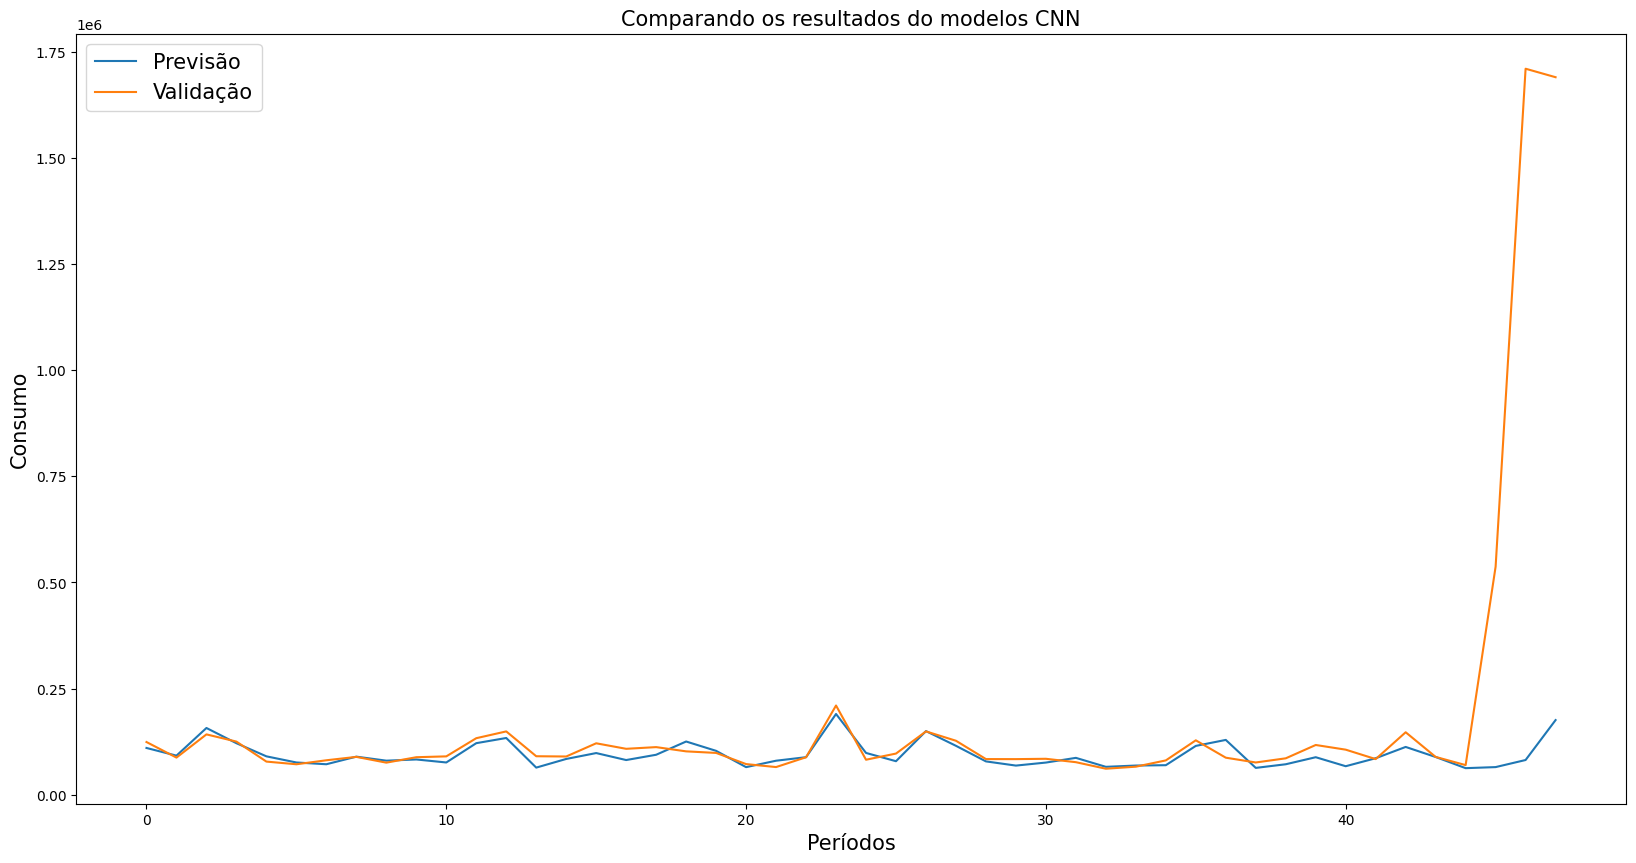

In [128]:
pd.DataFrame({'p':predictions_request[0,:], 'y':Yv_request[0,:]}).plot(figsize=(20,10))
plt.title('Comparando os resultados do modelos CNN',size=15)
plt.legend(['Previsão','Validação'],fontsize=15)
plt.xlabel('Períodos',size=15)
plt.ylabel('Consumo',size=15)

##LATENCY

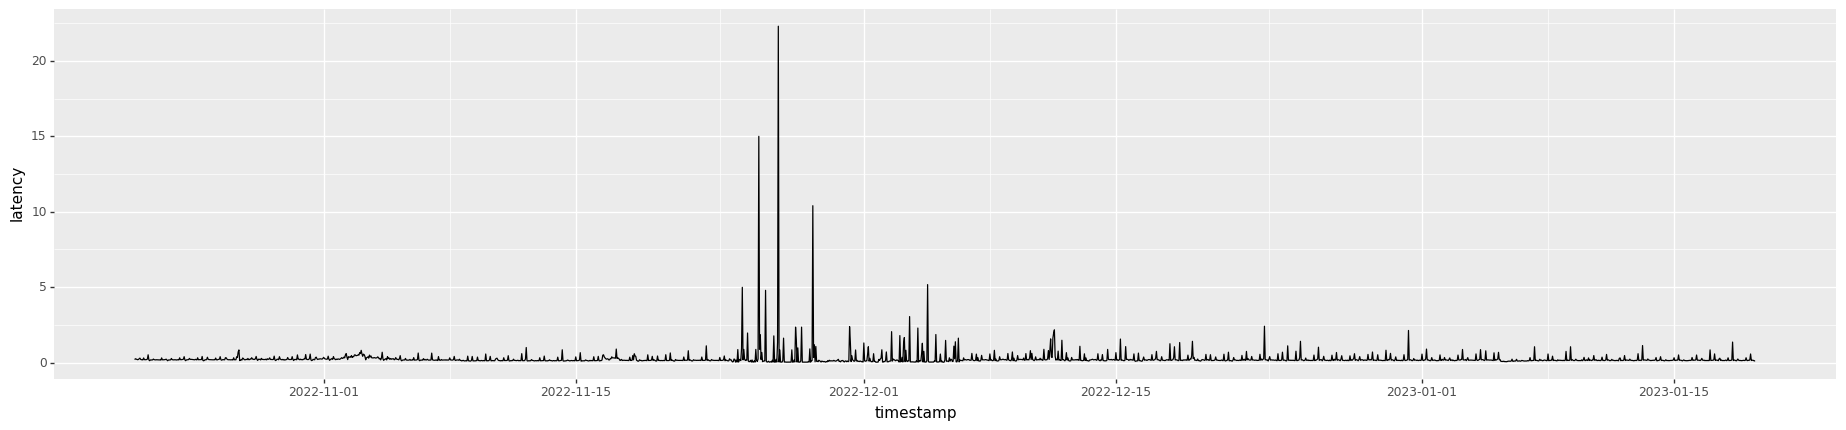

In [129]:
print(plot_data(df, 'latency'))

In [130]:
##LATENCY
#creating a training dataset
train_latency = pd.DataFrame(df[0:training_data_len]['timestamp'])
train_latency['latency'] = df[0:training_data_len]['latency']
train_latency.set_index('timestamp',inplace = True)

l=48
h=48

X_latency=[]
Y_latency=[]

for i in range(l,train_latency.shape[0]-h):
  f=train_latency.iloc[i-l:i]['latency'].values
  y=train_latency.iloc[i:i+h]['latency'].values

  X_latency.append(f)
  Y_latency.append(y)

X_latency=np.array(X_latency)
Y_latency=np.array(Y_latency)

#creating the test base
test_latency = pd.DataFrame(df[training_data_len:]['timestamp'])
test_latency['latency'] = df[training_data_len:]['latency']
test_latency.set_index('timestamp',inplace = True)

Xv_latency=[]
Yv_latency=[]

for i in range(l, test_latency.shape[0]-h):
  f=test_latency.iloc[i-l:i]['latency'].values
  y=test_latency.iloc[i:i+h]['latency'].values

  Xv_latency.append(f)
  Yv_latency.append(y)

Xv_latency=np.array(Xv_latency)
Yv_latency=np.array(Yv_latency)

In [131]:
start_latency = time.time()

In [132]:
model_latency=tf.keras.Model(numerical_i,out)
model_latency.compile('adam','mae')
model_latency.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 45, 20)            100       
                                                                 
 flatten_2 (Flatten)         (None, 900)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               270300    
                                                                 
 dense_5 (Dense)             (None, 48)                14448     
                                                                 
Total params: 284,848
Trainable params: 284,848
Non-trainable params: 0
_________________________________________________________________


In [133]:
#Treinamento: 10 épocas para treinamento do modelo.
model_latency.fit(X_latency,Y_latency,batch_size=1,shuffle=True,epochs=10)

Epoch 1/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.2802
Epoch 2/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2756
Epoch 3/10
1632/1632 [==============================] - 6s 3ms/step - loss: 0.2757
Epoch 4/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 5/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 6/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 7/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 8/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 9/10
1632/1632 [==============================] - 6s 4ms/step - loss: 0.2755
Epoch 10/10
1632/1632 [==============================] - 7s 4ms/step - loss: 0.2755


In [134]:
#Gerando as previsões do modelo
predictions_latency=model_latency.predict(Xv_latency)

11/11 [==============================] - 0s 2ms/step


In [135]:
p_base_latency = np.ones(Yv_latency.shape)*np.median(Y_latency,axis=0)

In [136]:
end_latency = time.time()

In [137]:
print('Erro médio absoluto :', mean_absolute_error(Yv_latency, p_base_latency))
print('Erro médio quadrado :', mean_squared_error(Yv_latency, p_base_latency))
print('Coeficiente de determinação (R²):', r2_score(Yv_latency, p_base_latency))
print("Tempo de execução:", end_latency-start_latency)

Erro médio absoluto : 0.05932844337289811
Erro médio quadrado : 0.020511713556503466
Coeficiente de determinação (R²): -0.014906675448317508
Tempo de execução: 82.99014401435852


Text(0, 0.5, 'Consumo')

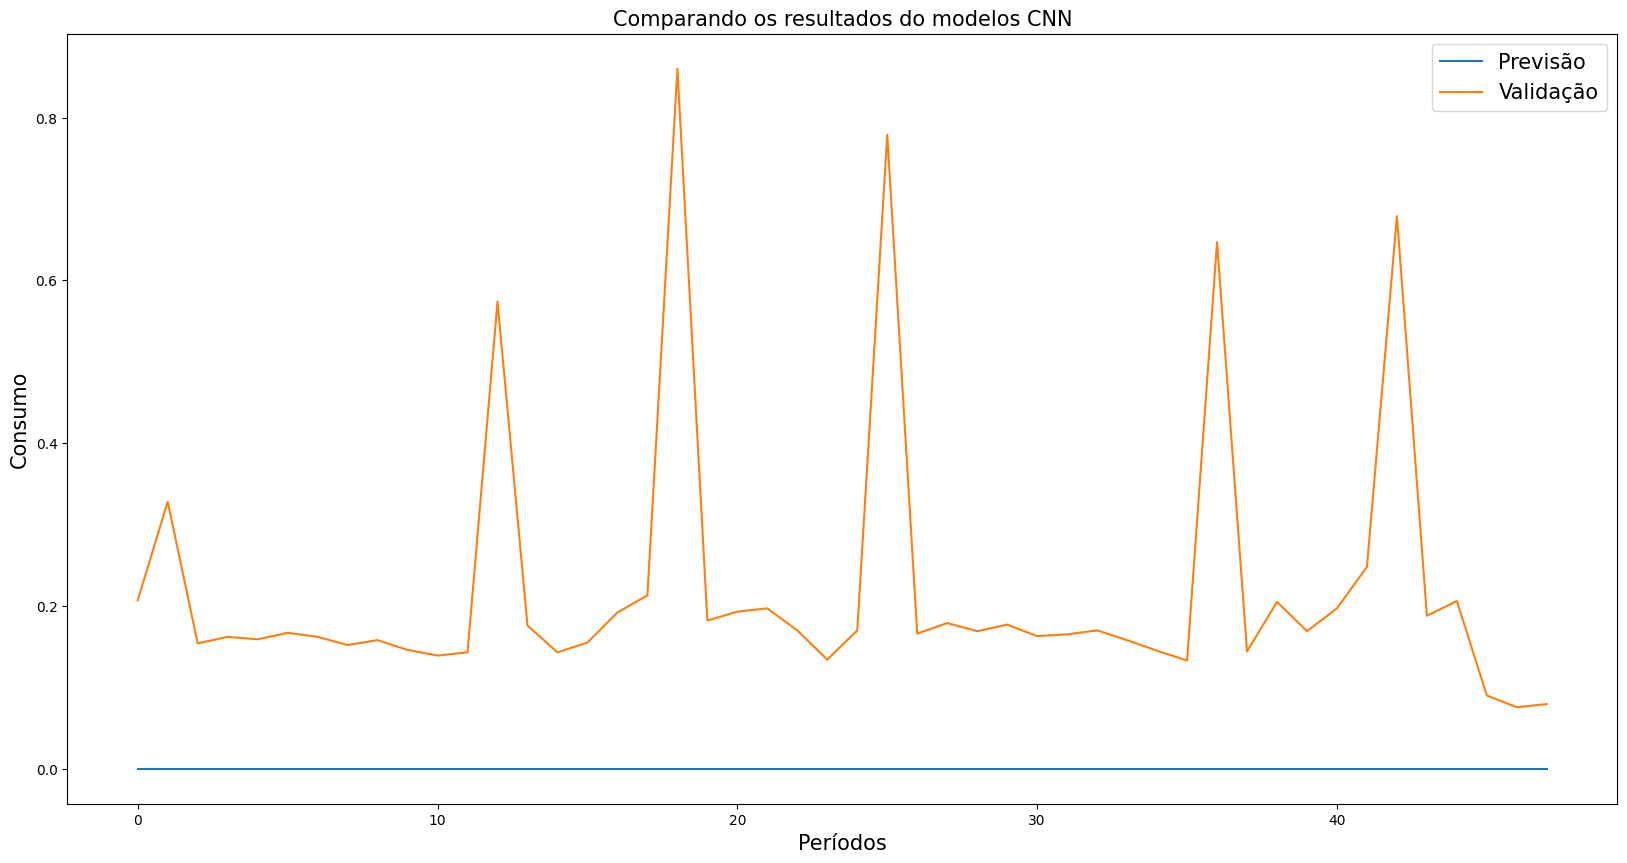

In [138]:
pd.DataFrame({'p':predictions_latency[0,:], 'y':Yv_latency[0,:]}).plot(figsize=(20,10))
plt.title('Comparando os resultados do modelos CNN',size=15)
plt.legend(['Previsão','Validação'],fontsize=15)
plt.xlabel('Períodos',size=15)
plt.ylabel('Consumo',size=15)